<a href="https://colab.research.google.com/github/tessamitchell/SchoolBusStopSignDetection/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Data Set Up

In [1]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from skimage.feature import local_binary_pattern
from skimage.feature import haar_like_feature
from skimage.feature import hog

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
# X=data
# y=data.labels

!pip install roboflow
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(api_key=userdata.get('roboflow'))
project = rf.workspace("myworkspace-hr4qa").project("stop-signs-custom-umjoj")
version = project.version(8)
dataset = version.download("voc")



loading Roboflow workspace...
loading Roboflow project...


In [126]:
import os
import random

def load_positive_windows(xml_path):
    pos_windows=[]
    neg_windows=[]

    for xml in os.listdir(xml_path):
      if xml.endswith(".xml"):
        img_name=xml.replace('.xml','.jpg')
        img_path = os.path.join(xml_path, img_name)
        if not os.path.exists(img_path):
            continue  # Skip if image file doesn't exist

        img=cv.imread(img_path)
        tree = ET.parse(os.path.join(xml_path, xml))
        root = tree.getroot()

        boxes = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) -1
            ymin = int(bbox.find("ymin").text) -1
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            pw=img[ymin:ymax,xmin:xmax]
            pw=cv.resize(pw,(64,64))
            if obj.find("name").text == "stop sign":
              pos_windows.append(pw)
            else:
              neg_windows.append(pw)

    return pos_windows,neg_windows

In [4]:
pos_images=neg_images=[]

In [127]:
import glob

xml_path = "/content/Stop-Signs-Custom-8/train/"
# xml_path = "/content/Stop-Sign-1/train/"
# xml_paths = glob.glob("/content/*/*.xml", recursive=True) # for train valid and test xml
pos_images,neg_images=load_positive_windows(xml_path)

In [10]:
# xml_path = "/content/Stop-Signs-Custom-6/train/"
# # xml_paths = glob.glob("/content/*/*.xml", recursive=True) # for train valid and test xml
# p2,n2=load_positive_windows(xml_path)
# pos_images.extend(p2)
# neg_images.extend(n2)

# Preprocessing

# Feature Extraction

[sci-kit lbp extraction](https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html)

In [9]:
# https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html

radius=3
n_points=8*radius
METHOD = 'ror'
def extract_lbp(img):
  res=local_binary_pattern(img,n_points,radius,METHOD)
  return res.flatten()




[scikit haar face extraction](https://scikit-image.org/docs/0.25.x/auto_examples/applications/plot_haar_extraction_selection_classification.html)

[haar general additional link](https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_haar.html)

In [10]:
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']
def extract_haar(img):
  haar=haar_like_feature(img,0,0,img.shape[0],img.shape[1])
  return haar

In [11]:
def extract_hog(img):
  feature=hog(img,orientations=9, pixels_per_cell=(16, 16),cells_per_block=(1, 1),visualize=False)
  return feature

In [12]:
def extract_features(img):
  return np.concatenate([extract_lbp(img),extract_hog(img)])

In [13]:
# print(len(pos_images))
# print(len(neg_images))
# from google.colab.patches import cv2_imshow
# pos_images = [cv.normalize(img,None,0,255,cv.NORM_MINMAX) for img in pos_images]
# for img in pos_images:
#   cv2_imshow(img)
# # cv2_imshow(pos_images[53])

NameError: name 'pos_images' is not defined

In [ ]:
# for img in neg_images:
#   cv2_imshow(img)

In [14]:
# X_features=[]
# y_labels=[]

# # for window in pos_images:
# #   X_features.append(extract_features(window))
# #   y_labels.append(1)
# #   print(len(X_features))

# # for window in neg_images:
# #   X_features.append(extract_features(window))
# #   y_labels.append(0)
# #   print(len(X_features))
# pos_images = [img[:,:,2] for img in pos_images]
# neg_images = [img[:,:,2] for img in neg_images]

# X_features = [extract_features(w) for w in pos_images] + \
#              [extract_features(w) for w in neg_images]

# y_labels   = [1] * len(pos_images) + [0] * len(neg_images)

# import joblib



# joblib.dump(X_features, "adaboost_features5.pkl")
# joblib.dump(y_labels,"adaboost_labels5.pkl")

NameError: name 'pos_images' is not defined

# Training (Adaboost Cascade)

Adding these links here for any tabs I opened in my research that I might want to come back to

[sklearn adaboost tutorial](https://www.datacamp.com/tutorial/adaboost-classifier-python)

[another adaboost tutorial](https://www.kdnuggets.com/2022/10/implementing-adaboost-scikitlearn.html)

[sklearn adaboost documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

[adaboost from scratch](https://medium.com/@enozeren/building-the-adaboost-model-from-scratch-with-python-db3a8a763484)

[from scratch G4G](https://www.geeksforgeeks.org/machine-learning/implementing-the-adaboost-algorithm-from-scratch/)

[sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [2]:
import joblib
X_features=joblib.load("adaboost_features.pkl")
y_labels=joblib.load("adaboost_labels.pkl")

In [130]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3,random_state=42) # 70% training and 30% test

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_test, y_pred))

# Accuracy: 0.8928571428571429
# Accuracy: 0.9642857142857143
# Accuracy: 0.9466666666666667
import joblib
joblib.dump(model, "adaboost_model5.pkl")
# 5 Accuracy: 0.9655172413793104

In [3]:
import joblib
model=joblib.load("adaboost_model5.pkl")

# Extract Regions of Interest

In [20]:
from imutils.object_detection import non_max_suppression
def extract_windows(img):
  windows=[]
  min_size=20
  for y in range(min_size,img.shape[0],8):
    for x in range(min_size, img.shape[1],8):
      windows.extend(pyramid(img,x,y))
  windows= non_max_suppression(windows, overlapThresh=0.3)

  # for y in range(0, img.shape[0] - window_size[1] + 1, step_size):
  #       for x in range(0, img.shape[1] - window_size[0] + 1, step_size):
  #           yield (x, y, img[y:y + window_size[1], x:x + window_size[0]])
  return windows

def pyramid(image, x,y, min_size=20):
    # yield image
    pos=[]
    h,w=image.shape
    size=min_size
    left=x-(size//2)
    top=y-(size//2)
    right =left+size
    bottom = top+size
    while( (left>=0) and (top>=0) and (right<w) and (bottom < h)  ):
      square=image[top:bottom,left:right]
      square= cv.resize(square,(64,64))
      feat=extract_features(square).reshape(1, -1)
      if(model.predict(feat)==1):
        pos.append((left,top,right,bottom))
      size+=20
      left=x-(size//2)
      top=y-(size//2)
      right = x+(size//2)
      bottom = y+(size//2)
    return pos


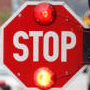

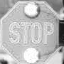

AttributeError: 'list' object has no attribute 'dtype'

In [21]:
import cv2 as cv
import numpy as np
testimg=cv.imread("/content/istockphoto-2157367693-612x612.jpg")
cropped=testimg[230:320,260:350]
# cropped=testimg[30:120,190:250]
# cropped=testimg[0:300,0:300]
from google.colab.patches import cv2_imshow
cv2_imshow(cropped)
cropped=cv.resize(cropped,(64,64))
red=cropped[:,:,2]

cv2_imshow(red)

img=testimg.copy()
img=img[:,:,2]
windows=extract_windows(img)
for (x,y,x2,y2) in windows:
  cv.rectangle(img,(x,y),(x2,y2),(0,255,0),2)
cv2_imshow(img)

# features=extract_features(red).reshape(1, -1)
# cv2_imshow(red)
# print(model.predict(features))



In [ ]:
testimages=[]
positive_windows=[]
for img in testimages:
  windows=extract_windows(img)
  for (x,y,w,h) in windows:
    patch=img[x:x+h,y:y+w]

    positive_windows.append((img,patch,x,y,w,h))

# Light Detection (Hough Circle Transform)

### Hough Circle Transform

In [7]:
def preprocess(img):
  blurred=cv.medianBlur(img,7)
  avg=blurred.mean()
  med = (blurred- avg)
  med=np.clip(med,0,255).astype(np.uint8)
  cv2_imshow(med)
  _,mask = cv.threshold(med,0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  cv2_imshow(mask)
  return med

# documentation https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
def houghAndValidation(img,orig):
  img=img.copy()
  orig=orig.copy()
  img=preprocess(img)
  h,w=img.shape
  minR=int(img.shape[1]/10)
  maxR=int(img.shape[1]/4)
  print(maxR)
  circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1.5,30,
                              param1=50,param2=20,minRadius=minR,maxRadius=maxR)
  if circles is None:
    return
  print(circles)
  circles = np.uint16(np.around(circles))
  # validation

  for c in circles[0]:
    print(c[2])
    right_edge=c[0]+c[2]
    left_edge=c[0]-c[2]
    top_edge=c[1]-c[2]
    bottom_edge=c[1]+c[2]
    if((right_edge<(w * (3/4)) and (left_edge>(w//4)))  and ((bottom_edge<(h/2)) or (top_edge>(h/2)))):
      cv.circle(orig, (c[0], c[1]), c[2], (0, 255, 0), 1)


    # compare radius with bounding box of stop sign

    # get average intensity value and compare to red section of stop sign

    # compare location
    # if(c[1]+c[2] < )
  cv2_imshow(orig)


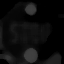

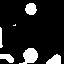

16
[[[30.75 54.75  6.6 ]]]
7


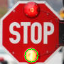

In [8]:
# pos_window format img,patch,x,y,w,h
# for img,patch,x,y,w,h in positive_windows:
#   hw=houghAndValidation(patch,img)
#   drawbounds(img,(hw),(x,y,w,h))
houghAndValidation(red,cropped)

# Outputs

In [ ]:
# https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html
def drawBounds(img,circle,box):
  x=box[0]
  y=box[1]
  for c in circle:
    cv.circle(img,(y+circle[0],x+circle[1]),circle[2],(255,0,0),2)

  cv.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)